In [ ]:
# default_exp baselines

# baselines

> API details.

In [ ]:
#export
#hide
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils.validation import check_is_fitted
from sktime.transformations.panel.rocket import Rocket
from sktime.utils.data_processing import from_3d_numpy_to_nested
import matplotlib.pyplot as plt
from fastcore.basics import listify
from fastcore.test import *
np.random.seed(23)
import numpy as np
from numba import njit

In [ ]:
def get_test_data(n_samples=20):
    _X = np.random.random_sample(n_samples)*np.pi
    _y = np.sin(_X) + np.random.randn(_X.shape[0])*0.1+1
    
    return _X.reshape(-1,1),_y

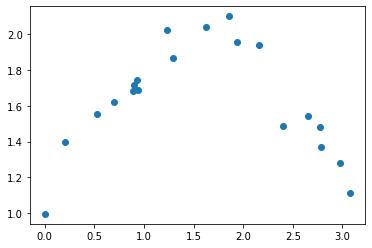

In [ ]:
Xt,yt = get_test_data()
plt.scatter(Xt, yt)
plt.show()

In [ ]:
#export
def _append_one_col(X):
    """append array with ones in order to replace a fitted bias in the output"""
    return np.hstack([np.ones((X.shape[0], 1)), X])

In [ ]:
#export 
#hide
@njit
def truncated_svd(x):
    u, s, vh = np.linalg.svd(x.transpose() @ x)
    s = np.sqrt(s)
    u_times_sigma = x @ vh.transpose()
    k = np.sum((s > 1e-10) * 1)  # rank of f
    s = s.reshape(-1, 1)
    s = s[:k]
    vh = vh[:k]
    u = u_times_sigma[:, :k] / s.reshape(1, -1)
    return u, s, vh

_tmp =truncated_svd(np.random.randn(20, 10).astype(np.float64))


def _fit_fixed_point(X: np.ndarray, y: np.ndarray, n_iter=100):
    """
    LogME calculation proposed in the arxiv 2021 paper
    "Ranking and Tuning Pre-trained Models: A New Paradigm of Exploiting Model Hubs"
    at https://arxiv.org/abs/2110.10545, source code is from https://github.com/thuml/LogME
    """
    N, D = X.shape
    u, s, vh, sigma = _fixed_point_svd(X)

    x, x2, res_x2 = prep_fixed_point_empircal_bayes(y, u)

    alpha, beta = 1.0, 1.0
    for idx in range(n_iter):
        t = alpha / beta
        gamma = (sigma / (sigma + t)).sum()
        m2 = (sigma * x2 / ((t + sigma) ** 2)).sum()
        res2 = (x2 / ((1 + sigma / t) ** 2)).sum() + res_x2
        alpha = gamma / (m2 + 1e-5)
        beta = (N - gamma) / (res2 + 1e-5)
        t_ = alpha / beta
        evidence = evidence_fixed_point(N, D, sigma, alpha, beta, m2, res2)
        evidence /= N
        if abs(t_ - t) / t <= 1e-3:  # abs(t_ - t) <= 1e-5 or abs(1 / t_ - 1 / t) <= 1e-5:
            break
            
    if idx+1==n_iter:
        print(f"Optimization of alpha {alpha:0.2f} and beta {beta:0.2f} not terminated. ")
        
    evidence = evidence_fixed_point(N, D, sigma, alpha, beta, m2, res2)
    
    evidence /= N
    w_mean = 1.0 / (t + sigma) * s * x
    w_mean = (vh.T @ w_mean).reshape(-1)
    identity_matrix = np.eye(np.size(X,1))
    w_precision = alpha * identity_matrix + beta * X.T@X
    return w_mean, w_precision, alpha, beta

def prep_fixed_point_empircal_bayes(y, u):
    y = y.reshape(-1, 1)
    x = u.T @ y  # x has shape [k, 1], but actually x should have shape [N, 1]
    x2 = x ** 2
    res_x2 = (y ** 2).sum() - x2.sum()  # if k < N, we compute sum of xi for 0 singular values directly
    return x,x2,res_x2

def _fixed_point_svd(X):
    N, D = X.shape  # k = min(N, D)
    if N > D: # direct SVD may be expensive
        u, s, vh = truncated_svd(X)
    else:
        u, s, vh = np.linalg.svd(X, full_matrices=False)
    # u.shape = N x k
    # s.shape = k
    # vh.shape = k x D
    s = s.reshape(-1, 1)
    sigma = (s ** 2)
    return u,s,vh,sigma

def evidence_fixed_point(N, D, sigma, alpha, beta, m2, res2):
    evidence = D / 2.0 * np.log(alpha) \
                + N / 2.0 * np.log(beta) \
                - 0.5 * np.sum(np.log(alpha + beta * sigma)) \
                - beta / 2.0 * res2 \
                - alpha / 2.0 * m2 \
                - N / 2.0 * np.log(2 * np.pi)
                
    return evidence

In [ ]:
#export
class BayesLinReg(BaseEstimator):
    """Batch wise linear regression"""

    def __init__(self,  alpha:float=1., beta:float=1., 
                 empirical_bayes:bool=True, n_iter:int=100,
                use_fixed_point=False):
        self.alpha = alpha
        self.beta = beta
        self.n_features = None
        self.n_iter = n_iter
        self.empirical_bayes = empirical_bayes
        self.use_fixed_point = use_fixed_point


    def _create_matrices(self, X):
        if self.n_features is None:
            self.n_features = X.shape[1]

            self.w_mean = np.zeros(self.n_features)
            self.w_precision = np.identity(self.n_features) * self.alpha

    def fit_empirical_bayes(self, X, y):
        X,y = self._check_and_prep(X, y)
        """
           Fitting empirical bayes based on training data to determine alpha and beta.
           This can be used when N>>M (more training samples than parameters).
        """

        M = X.T @ X
        eigenvalues = np.linalg.eigvalsh(M)
        identity_matrix = np.eye(np.size(X,1))#np.identity(self.n_features)
        N = len(X)
        xTy = X.T @ y

        for idx in range(self.n_iter):
            params = [self.alpha, self.beta]

            # update the inverse covariance matrix (Bishop eq. 3.51)
            w_precision = self.alpha * identity_matrix + self.beta * M
            # update the mean vector (Bishop eq. 3.50)
            w_mean = self.beta * np.linalg.solve(w_precision, xTy)

            # TODO (Bishop eq. 3.91)
            gamma = np.sum(eigenvalues / (self.alpha + eigenvalues))
            # TODO (Bishop eq. 3.98)
            self.alpha = float(gamma / np.sum(w_mean ** 2).clip(min=1e-10))

            # TODO (Bishop eq. 3.99)
            self.beta = float((N-gamma) / np.sum(np.square(y - X @ w_mean)))

            if np.allclose(params, [self.alpha, self.beta]):
                break

        if idx+1==self.n_iter:
            print(f"Optimization of alpha {self.alpha:0.2f} and beta {self.beta:0.2f} not terminated. ")

        self.w_mean = w_mean
        self.w_precision = w_precision
        # calculate the covariance in advance for faster inference
        self.w_covariance = np.linalg.inv(w_precision)


    def fit_fixed_point(self, X, y):
        X = np.atleast_2d(X)
        X = _append_one_col(X)
        
        self.w_mean, self.w_precision, self.alpha, self.beta = _fit_fixed_point(X,y, n_iter=self.n_iter)
        # import so that model is not creating new matrices
        self.n_features = X.shape[1]
        
        self.w_covariance = np.linalg.inv(self.w_precision)
        
    def fit(self, X, y):
        if self.use_fixed_point:
            self.fit_fixed_point(X,y)
        elif self.empirical_bayes:
            self.fit_empirical_bayes(X,y)
        else:
            self.update(X,y)

        return self

    def _check_and_prep(self, X, y = None):
        X = np.atleast_2d(X)
        X = _append_one_col(X)

        self._create_matrices(X)
        if y is None:
            return X
        else:
            y = np.atleast_1d(y)
            return X,y

    def update(self, X, y):
        X, y = self._check_and_prep(X, y)

        # update the inverse covariance matrix (Bishop eq. 3.51)
        w_precision = self.w_precision + self.beta * X.T @ X

        # update the mean vector (Bishop eq. 3.50)
        w_covariance = np.linalg.inv(w_precision)
        w_mean = w_covariance @ (self.w_precision @ self.w_mean + self.beta * y @ X)

        self.w_precision = w_precision
        self.w_covariance = np.linalg.inv(w_precision)
        self.w_mean = w_mean

        return self

    def _predict(self,X):
        X = self._check_and_prep(X)

        # calcualte the predictive mean (Bishop eq. 3.58)
        y_pred_mean = X @ self.w_mean

        # calculate the predictive variance (Bishop eq. 3.59)
        y_pred_var = 1 / self.beta + (X @ self.w_covariance * X).sum(axis=1)

        # Drop a dimension from the mean and variance in case x and y were singletons
        # There might be a more elegant way to proceed but this works!
        y_pred_mean = np.squeeze(y_pred_mean)
        y_pred_var = np.squeeze(y_pred_var)

        return y_pred_mean, y_pred_var ** 0.5


    def predict(self, X):
        y_pred_mean, _ =self._predict(X)
        return y_pred_mean

    def predict_proba(self, X):
        y_pred_mean, y_pred_std = self._predict(X)
        return y_pred_mean, y_pred_std

    def _log_prior(self, w):
        return -0.5 * self.alpha * np.sum(w ** 2)

    def _log_likelihood(self, X, y, w):
        return -0.5 * self.beta * np.square(y - X @ w).sum()

    def _log_posterior(self, X, y, w):
        return self._log_likelihood(X, y, w) + self._log_prior(w)
    
    def log_prior(self):
        return self._log_prior(self.w_mean)
    
    def log_posterior(self, X, y):
        X = self._check_and_prep(X)
        return self._log_likelihood(X, y, self.w_mean) + self._log_prior(self.w_mean)
    
    def log_likelihood(self, X, y):
        X = self._check_and_prep(X)
        return self._log_likelihood(X, y, self.w_mean) + self._log_prior(self.w_mean)

    def log_evidence(self, X:np.ndarray, y:np.ndarray):
        # for compability reasons with older versions
        if getattr(self, 'use_fixed_point', False):
            N,D = X.shape
            t = self.alpha / self.beta
            u, s, vh, sigma = _fixed_point_svd(X)
            x, x2, res_x2 = prep_fixed_point_empircal_bayes(y, u)
            res2 = (x2 / ((1 + sigma / t) ** 2)).sum() + res_x2
            m2 = (sigma * x2 / ((t + sigma) ** 2)).sum()

            return evidence_fixed_point(N, D, sigma, self.alpha, self.beta, m2, res2)

        else:
            X, y = self._check_and_prep(X, y)

            N, M = X.shape

            # E(\mathbf{m}_n) = \beta/2 \cdot ||y- X \mathbf{m}_n|| + \alpha/2 \mathbf{m}_n^T \mathbf{m}_n, 
            # where \mathbf{m}_n is the mean weight. This is the same as the negative of the posterior       
            Emn = -self._log_posterior(X, y, self.w_mean)

            # Bishop eq. 3.86         
            return 0.5 * (M * np.log(self.alpha) + N * np.log(self.beta)
                - np.linalg.slogdet(self.w_precision)[1] - N * np.log(2 * np.pi)
            ) - Emn

In [ ]:
# hide
np.random.seed(42)
# test if the log evidence decreases with increasing noise in the input data
def create_noisy_data(n_samples, noise_level=0):
    X = np.random.uniform(size=n_samples)
    y = 2*X+np.random.randn(n_samples)*0.1
    
    X = X + np.random.normal(scale=noise_level, size=n_samples)
    
    return X.reshape(-1,1), y.ravel()

X,y = create_noisy_data(100, noise_level=0.0)
model = BayesLinReg(empirical_bayes=True)
model = model.fit(X,y)
previous_evidence = model.log_evidence(X,y)
for noise_level in [0.1, 0.25, 0.5, 1]:
    X,y = create_noisy_data(100, noise_level=noise_level)
    model = BayesLinReg(empirical_bayes=True)
    model = model.fit(X,y)
    
    cur_evidence = model.log_evidence(X,y)
    test_eq(True, cur_evidence<previous_evidence)
    previous_evidence=cur_evidence

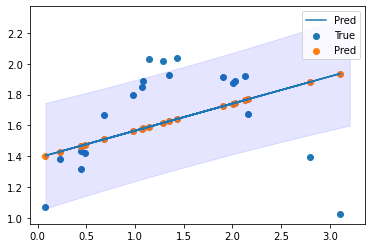

In [ ]:
# train data
Xt,yt = get_test_data()
model = BayesLinReg(use_fixed_point=False, n_iter=10)
model = model.fit(Xt,yt)

# test data
X,y = get_test_data()
yhat, ystd = model.predict_proba(X)

fig, ax = plt.subplots()
ax.scatter(X, y, label="True")
ax.scatter(X, yhat, label="Pred")
ax.plot(X, yhat, label="Pred")

x_range = np.arange(np.min(X), np.max(X)+0.1, step=0.001).reshape(-1,1)
yhat, ystd = model.predict_proba(x_range)
ax.fill_between(x_range.reshape(-1), (yhat-ystd), (yhat+ystd), color='b', alpha=.1)

plt.legend()
plt.show()

In [ ]:
#export
class RidgeRegression(BaseEstimator):
    def __init__(self, l2_reg=1e-3):
        self.l2_reg = l2_reg

    def _ridge_regression(self, X, y):
        """ridge / tikhonov regularized linear multiple, multivariate regression"""
        return np.linalg.inv(X.T @ X + self.l2_reg * np.eye(X.shape[1])) @ X.T @ y

    def fit(self, X, y):
        X = _append_one_col(X)
        self.W = self._ridge_regression(X, y)

        return self

    def predict(self, X):
        X = _append_one_col(X)
        y_hat = X @ self.W

        return y_hat

In [ ]:
#export
def relu(x):
    return np.maximum(x, 0)

def identity(x):
    return x

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [ ]:
#export
#hide
tmp = ["2"]
test_acts = "relu,sigmoid"
tmp += test_acts.split(",")
test_eq(tmp, ['2', 'relu', 'sigmoid'])

In [ ]:
#export
class ELM(BaseEstimator):
    def __init__(
        self, n_hidden=20, activations=relu, prediction_model=BayesLinReg(),
                include_original_features=True,**kwargs):

        """[summary]

        Args:
            n_hidden (int, optional): [description]. Defaults to 100.
            activations ([type], optional): [description]. Defaults to relu.
            prediction_model_type (str, optional): [description]. Defaults to "ridge".
        """

        self.prediction_model = prediction_model
        self.n_hidden = n_hidden
        self.include_original_features = include_original_features
        self._hidden_weights, self._biases  = None, None

        if self.prediction_model is None:
            self._prediction_model = BayesLinReg()
        else:
            self._prediction_model = self.prediction_model

        self._convert_activations(activations)

        super(ELM).__init__()

    def _convert_activations(self, activations):
        self.activations = []
        activations = listify(activations)
        conversion_dict = {"relu": relu, "identity": identity, "sigmoid": sigmoid,
                           "tanh": np.tanh}
        supported_activations = list(conversion_dict.keys())

        for activation in activations:
            if type(activation) is str:
                activation = activation.split(",")
                for act in activation:
                    if act in supported_activations:
                        self.activations.append(conversion_dict[act])
            elif callable(activation):
                self.activations.append(activation)
                
    @property
    def alpha(self):
        return self._prediction_model.alpha
    
    @property
    def beta(self):
        return self._prediction_model.beta
    
    @alpha.setter
    def alpha(self, alpha):
        self._prediction_model.alpha = alpha
        
    @beta.setter
    def beta(self, beta):
        self._prediction_model.beta = beta

    def transform_X(self, X, W, b, activations):
        G = np.dot(X, W) + b
        Hs = []
        for act in activations:
            Hs.append(act(G))
        return np.concatenate(Hs, axis=1)

    def _check_and_prep(self, X, y):
        X, y = self._validate_data(X, y, y_numeric=True, multi_output=True)

        self._n_features = X.shape[1]
        if self._hidden_weights is None:
            self._hidden_weights = 0.1*np.random.normal(size=[self._n_features, self.n_hidden])
            self._biases = 0.1*np.random.normal(size=[self.n_hidden])


        X_transformed = self.transform_X(
            X, self._hidden_weights, self._biases, self.activations
        )

        if self.include_original_features:
            X_transformed = np.concatenate([X_transformed, X], axis=1)

        return X_transformed, y

    def fit(self, X, y):

        X_transformed, y = self._check_and_prep(X, y)

        self._prediction_model.fit(X_transformed, y)

        return self

    def update(self, X, y):

        X_transformed, y = self._check_and_prep(X, y)

        self._prediction_model.update(X_transformed, y)

        return self

    def _prep_pred_X(self, X):
         # Check is fit had been called
        check_is_fitted(self)

        X = self._validate_data(X)

        X_transformed = self.transform_X(
            X, self._hidden_weights, self._biases, listify(self.activations)
        )

        if self.include_original_features:
            X_transformed = np.concatenate([X_transformed, X], axis=1)

        return X_transformed


    def predict(self, X):
        X_transformed = self._prep_pred_X(X)
        y_hat = self._prediction_model.predict(X_transformed)

        return y_hat

    def predict_proba(self, X):
        X_transformed = self._prep_pred_X(X)
        return self._prediction_model.predict_proba(X_transformed)

    def set_params(self, **params):
        local_param_keys = self.get_params(deep=False).keys()
        local_params = {k: v for (k, v) in params.items() if k in local_param_keys}

        for k, v in local_params.items():
            setattr(self, k, v)

        # assume that remaining keys must be part of the prediction model
        non_local_params = {
            k: v for (k, v) in params.items() if k not in local_param_keys
        }
        self.prediction_model.set_params(**non_local_params)

    def get_params(self, deep=False):
        return super().get_params()

    def log_evidence(self, X:np.ndarray, y:np.ndarray, logme=False):
        X_transformed = self._prep_pred_X(X)
        evidence =  self._prediction_model.log_evidence(X_transformed, y)
        
        if logme:
            evidence = evidence / len(X)
        return evidence
    
    def log_likelihood(self, X:np.ndarray, y:np.ndarray):
        X_transformed = self._prep_pred_X(X)
        
        log_likelihood = self._prediction_model.log_likelihood(
            X_transformed,  y.reshape(-1)
        )
        
        return log_likelihood
    
    def log_prior(self):
        return self._prediction_model.log_prior()
    
    def log_posterior(self, X:np.ndarray, y:np.ndarray):
        X_transformed = self._prep_pred_X(X)

        log_posterior = self._prediction_model.log_posterior(
            X_transformed, y.reshape(-1)
        )
        
        return log_posterior

In [ ]:
# hide
np.random.seed(23)
# test if the log evidence decreases with increasing noise in the input data
def create_noisy_data(n_samples, noise_level=0):
    X = np.random.uniform(size=n_samples)
    y = 2*X+np.random.randn(n_samples)*0.1
    
    X = X + np.random.normal(scale=noise_level, size=n_samples)
    
    return X.reshape(-1,1), y.ravel()

X,y = create_noisy_data(200, noise_level=0.0)
model = ELM(n_hidden=10,prediction_model=BayesLinReg(empirical_bayes=True))
model = model.fit(X,y)
previous_evidence = model.log_evidence(X,y)
for noise_level in [0.1, 0.25, 0.5, 1]:
    X,y = create_noisy_data(100, noise_level=noise_level)
    model = ELM(n_hidden=10,prediction_model=BayesLinReg(empirical_bayes=True))
    model = model.fit(X,y)
    
    cur_evidence = model.log_evidence(X,y)
    test_eq(True, cur_evidence<previous_evidence)
    previous_evidence=cur_evidence
    
# make sure all functions are working
f= model.log_posterior(X,y)
test_eq(np.float64, type(f))
f= model.log_likelihood(X,y)
test_eq(np.float64, type(f))
f= model.log_prior()
test_eq(np.float64, type(f))

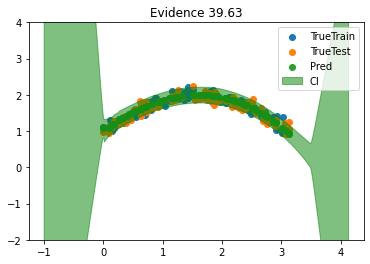

In [ ]:
X,y = get_test_data(n_samples=100)

model = ELM(n_hidden=10, activations=[np.sin], prediction_model=BayesLinReg(alpha=1, beta=10))
model = model.fit(X,y)

model = ELM(n_hidden=10, activations="sigmoid,relu", prediction_model=BayesLinReg(alpha=1, beta=10))
model = model.fit(X,y)

fig, ax = plt.subplots()
ax.scatter(X, y, label="TrueTrain")

# test data
X,y = get_test_data(n_samples=100)
yhat, ystd = model.predict_proba(X)


ax.scatter(X, y, label="TrueTest")
ax.scatter(X, yhat, label="Pred")

x_range = np.arange(np.min(X)-1, np.max(X)+1, step=0.001).reshape(-1,1)
yhat, ystd = model.predict_proba(x_range)
ax.fill_between(x_range.reshape(-1), (yhat-1.96*ystd), (yhat+1.96*ystd), color='g', alpha=.5, label="CI")

log_evidence = model.log_evidence(X,y)
plt.title(f"Evidence {log_evidence:0.02f}")
plt.ylim((-2,4))
plt.legend()
plt.show()

We might be interested in getting samples from the Bayesian linear or Bayesian ELM model.

In [ ]:
#export
def sample_bayes_linear_model(model, X, n_samples=100):
    if isinstance(model, ELM):
        X = model._prep_pred_X(X)
        prediction_model = model.prediction_model
    elif isinstance(model, BayesLinReg):
        prediction_model = model
    else:
        raise ValueError("Not supported model.")
        
    # add bias
    X = _append_one_col(X)
    
    sampled_mean = np.random.multivariate_normal(prediction_model.w_mean.reshape(-1),\
                                                 prediction_model.w_covariance, size=n_samples)
    y_sampled = X @ sampled_mean.T
    
    return y_sampled

In [ ]:
#hide
X_sample_test,y_sample_test = get_test_data()
model_sample_test = BayesLinReg()
model_sample_test = model_sample_test.fit(X_sample_test,y_sample_test)
samples = sample_bayes_linear_model(model, X[0:3,:], n_samples=2)
test_eq(samples.shape, [3,2])
# assure randomness
samples_2 = sample_bayes_linear_model(model, X[0:3,:], n_samples=2)
test_ne(samples, samples_2)

<ipython-input-16-bf128b1de62c>:14: RuntimeWarning: covariance is not positive-semidefinite.
  sampled_mean = np.random.multivariate_normal(prediction_model.w_mean.reshape(-1),\
<ipython-input-16-bf128b1de62c>:14: RuntimeWarning: covariance is not positive-semidefinite.
  sampled_mean = np.random.multivariate_normal(prediction_model.w_mean.reshape(-1),\


In [ ]:
sample_bayes_linear_model(model, X[0:3,:], n_samples=2)

<ipython-input-16-bf128b1de62c>:14: RuntimeWarning: covariance is not positive-semidefinite.
  sampled_mean = np.random.multivariate_normal(prediction_model.w_mean.reshape(-1),\


array([[1.43426673, 1.40652201],
       [1.95401251, 1.90933148],
       [1.73627325, 1.73470814]])

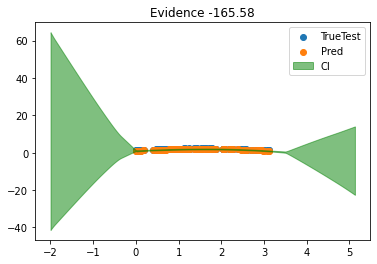

In [ ]:

X,y = get_test_data(n_samples=100)
y = y+0.25
yhat, ystd = model.predict_proba(X)

fig, ax = plt.subplots()
ax.scatter(X, y, label="TrueTest")
ax.scatter(X, yhat, label="Pred")

x_range = np.arange(np.min(X)-2, np.max(X)+2, step=0.001).reshape(-1,1)
yhat, ystd = model.predict_proba(x_range)
ax.fill_between(x_range.reshape(-1), (yhat-1.96*ystd), (yhat+1.96*ystd), color='g', alpha=.5, label="CI")

log_evidence = model.log_evidence(X,y)
plt.title(f"Evidence {log_evidence:0.02f}")
plt.legend()
plt.show()

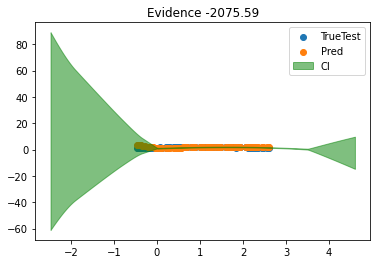

In [ ]:

X,y = get_test_data(n_samples=100)
X = X-0.5
yhat, ystd = model.predict_proba(X)

fig, ax = plt.subplots()
ax.scatter(X, y, label="TrueTest")
ax.scatter(X, yhat, label="Pred")

x_range = np.arange(np.min(X)-2, np.max(X)+2, step=0.001).reshape(-1,1)
yhat, ystd = model.predict_proba(x_range)
ax.fill_between(x_range.reshape(-1), (yhat-1.96*ystd), (yhat+1.96*ystd), color='g', alpha=.5, label="CI")

log_evidence = model.log_evidence(X,y)
plt.title(f"Evidence {log_evidence:0.02f}")
plt.legend()
plt.show()

In [ ]:
# export
class MCLeanPowerCurve(BaseEstimator):
    def __init__(self, power_curve_type="upland", normalize_ws=False):
        self.power_curve_type = power_curve_type
        self.normalize_ws = normalize_ws

    def fit(self, X, y=None, **kwargs):
        return self

    def predict(self, X):

        ws_ref = np.arange(0, 31)

        if self.power_curve_type == "offshore":
            pow_ref = [
                0,
                0,
                0,
                1,
                2,
                5,
                8,
                14,
                20,
                29,
                40,
                53,
                64,
                76,
                84,
                89,
                89,
                89,
                89,
                89,
                83,
                71,
                54,
                36,
                18,
                6,
                0,
                0,
                0,
                0,
                0,
            ]
        elif self.power_curve_type == "lowland":  # < 400
            pow_ref = [
                0,
                0,
                0,
                1,
                3,
                6,
                11,
                17,
                25,
                35,
                47,
                60,
                72,
                81,
                88,
                92,
                94,
                94,
                94,
                90,
                83,
                72,
                56,
                38,
                23,
                11,
                4,
                0,
                0,
                0,
                0,
            ]
        elif self.power_curve_type == "lowland_stall_regulated":
            pow_ref = [
                0,
                0,
                1,
                2,
                4,
                8,
                14,
                21,
                30,
                40,
                51,
                61,
                69,
                76,
                82,
                87,
                89,
                90,
                90,
                85,
                75,
                63,
                47,
                30,
                17,
                8,
                2,
                0,
                0,
                0,
                0,
            ]
        elif self.power_curve_type == "upland":
            pow_ref = [
                0,
                1,
                2,
                3,
                6,
                10,
                15,
                21,
                30,
                39,
                49,
                58,
                67,
                75,
                82,
                87,
                91,
                91,
                88,
                82,
                73,
                63,
                52,
                42,
                31,
                21,
                13,
                6,
                2,
                0,
                0,
            ]
        else:  # same as upland
            self.pow_ref = [
                0,
                1,
                2,
                3,
                6,
                10,
                15,
                21,
                30,
                39,
                49,
                58,
                67,
                75,
                82,
                87,
                91,
                91,
                88,
                82,
                73,
                63,
                52,
                42,
                31,
                21,
                13,
                6,
                2,
                0,
                0,
            ]

        pow_ref = np.array(pow_ref) / 100.0

        if self.normalize_ws:
            # as we start by there it is sufficient to normalize via the max value
            return np.interp(X, ws_ref / ws_ref.max(), pow_ref)
        else:
            return np.interp(X, ws_ref, pow_ref)


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00a_utils.ipynb.
Converted 00b_losses.ipynb.
Converted 00c_utils_blitz.ipynb.
Converted 00d_baselines.ipynb.
Converted 00e_metrics.ipynb.
Converted 00f_utils_pytorch.ipynb.
Converted 01_tabular.core.ipynb.
Converted 02_tabular.data.ipynb.
Converted 03_tabular.model.ipynb.
Converted 04_tabular.learner.ipynb.
Converted 05_timeseries.core.ipynb.
Converted 06_timeseries.data.ipynb.
Converted 07_timeseries.model.ipynb.
Converted 08_timeseries.learner.ipynb.
Converted 09_gan.core.ipynb.
Converted 10_gan.model.ipynb.
Converted 11_gan.learner.ipynb.
Converted 12_autoencoder_models.ipynb.
Converted 13_probabilistic_models.ipynb.
Converted 14_transfer_models.ipynb.
Converted 15_ensemble_models.ipynb.
Converted index.ipynb.
